# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [287]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [288]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

In [289]:
!wget -c http://ufldl.stanford.edu/housenumbers/train_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat

--2021-08-25 10:02:15--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

--2021-08-25 10:02:16--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Reusing existing connection to ufldl.stanford.edu:80.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [290]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Все функции, в которых мы будем вычислять градиенты, будут написаны по одной и той же схеме.  
Они будут получать на вход точку, где нужно вычислить значение и градиент функции, а на выходе будут выдавать кортеж (tuple) из двух значений - собственно значения функции в этой точке (всегда одно число) и аналитического значения градиента в той же точке (той же размерности, что и вход).
```
def f(x):
    """
    Computes function and analytic gradient at x
    
    x: np array of float, input to the function
    
    Returns:
    value: float, value of the function 
    grad: np array of float, same shape as x
    """
    ...
    
    return value, grad
```

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в функции `check_gradient` в `gradient_check.py`. Эта функция будет принимать на вход функции формата, заданного выше, использовать значение `value` для вычисления численного градиента и сравнит его с аналитическим - они должны сходиться.

Напишите часть функции, которая вычисляет градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)

Все функции приведенные в следующей клетке должны проходить gradient check.

In [291]:
def check_gradient(f, x, delta=1e-5, tol = 1e-4):
    '''
    Checks the implementation of analytical gradient by comparing
    it to numerical gradient using two-point formula
    Arguments:
      f: function that receives x and computes value and gradient
      x: np array, initial point where gradient is checked
      delta: step to compute numerical gradient
      tol: tolerance for comparing numerical and analytical gradient
    Return:
      bool indicating whether gradients match or not
    '''
    assert isinstance(x, np.ndarray)
    assert x.dtype == np.float
    
    orig_x = x.copy()
    fx, analytic_grad = f(x)
    assert np.all(np.isclose(orig_x, x, tol)), "Functions shouldn't modify input variables"
    assert analytic_grad.shape == x.shape
    analytic_grad = analytic_grad.copy()

    # We will go through every dimension of x and compute numeric
    # derivative for it
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index
        analytic_grad_at_ix = analytic_grad[ix]
        l = x.copy()
        l[ix] = l[ix]+tol
        numeric_grad_at_ix = (f(l)[0]-f(x)[0])/tol
        # TODO compute value of numeric gradient of f to idx
        if not np.isclose(numeric_grad_at_ix, analytic_grad_at_ix, tol):
            print("Gradients are different at %s. Analytic: %2.4f, Numeric: %2.4f" % (ix, analytic_grad_at_ix, numeric_grad_at_ix))
            return False

        it.iternext()

    print("Gradient check passed!")
    return True


In [292]:
it = np.nditer(np.array([[3.0, 2.0], [1.0, 0.0]]), flags=['multi_index'], op_flags=['readwrite'])
it.iternext()
it.iternext()
ix = it.multi_index
ix

(1, 0)

In [293]:
# TODO: Implement check_gradient function in gradient_check.py
# All the functions below should pass the gradient check

def square(x):
    return float(x*x), 2*x

check_gradient(square, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

Gradient check passed!
Gradient check passed!
Gradient check passed!


True

In [294]:
np.ones_like( np.array([[3.0, 2.0], [1.0, 0.0]]))

array([[1., 1.],
       [1., 1.]])

## Начинаем писать свои функции, считающие аналитический градиент

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [295]:
def softmax(predictions):
    '''
    Computes probabilities from scores
    Arguments:
      predictions, np array, shape is either (N) or (batch_size, N) -
        classifier output
    Returns:
      probs, np array of the same shape as predictions - 
        probability for every class, 0..1
    '''
    predictions = predictions.copy()
    predictions -= np.max(predictions)
    return np.exp(predictions) / np.sum(np.exp(predictions))
    # TODO implement softmax
    # Your final implementation shouldn't have any loops

In [296]:
# TODO Implement softmax and cross-entropy for single sample
linear_classifer.softmax = softmax
probs = linear_classifer.softmax(np.array([-10, 0, 10]))

# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
assert np.isclose(probs[0], 1.0)

Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [297]:
def cross_entropy_loss(probs, target_index):
    '''
    Computes cross-entropy loss
    Arguments:
      probs, np array, shape is either (N) or (batch_size, N) -
        probabilities for every class
      target_index: np array of int, shape is (1) or (batch_size) -
        index of the true class for given sample(s)
    Returns:
      loss: single value
    '''
    # TODO implement cross-entropy
    # Your final implementation shouldn't have any loops
    return np.mean(-np.log(probs).T[target_index])

In [298]:
linear_classifer.cross_entropy_loss = cross_entropy_loss
probs = linear_classifer.softmax(np.array([-5, 0, 5]))
linear_classifer.cross_entropy_loss(probs, 1)

5.006760443547122

После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [299]:
def softmax_with_cross_entropy(predictions, target_index):
    '''
    Computes softmax and cross-entropy loss for model predictions,
    including the gradient
    Arguments:
      predictions, np array, shape is either (N) or (batch_size, N) -
        classifier output
      target_index: np array of int, shape is (1) or (batch_size) -
        index of the true class for given sample(s)
    Returns:
      loss, single value - cross-entropy loss
      dprediction, np array same shape as predictions - gradient of predictions by loss value
    '''
    # TODO implement softmax with cross-entropy
    # Your final implementation shouldn't have any loops
    zeros = np.zeros_like(predictions)
    if (type(target_index) != int):
      grad=linear_classifer.softmax(predictions)-target_index
    else:
      zeros[target_index] = 1
      grad=linear_classifer.softmax(predictions)-zeros
    loss = cross_entropy_loss(linear_classifer.softmax(predictions),target_index)
    return loss, grad

In [300]:
linear_classifer.softmax_with_cross_entropy = softmax_with_cross_entropy 
# TODO Implement combined function or softmax and cross entropy and produces gradient
loss, grad = linear_classifer.softmax_with_cross_entropy(np.array([1, 0, 0]), 1)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, 1), np.array([1, 0, 0], np.float))

Gradient check passed!


True

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [301]:
def softmax(predictions):
    '''
    Computes probabilities from scores
    Arguments:
      predictions, np array, shape is either (N) or (batch_size, N) -
        classifier output
    Returns:
      probs, np array of the same shape as predictions - 
        probability for every class, 0..1
    '''
    predictions = predictions.copy()
    
    if len(predictions.shape) >1:
      predictions-=np.max(predictions,axis = 1).reshape(predictions.shape[0],-1)
      return (np.exp(predictions).T/(np.sum(np.exp(predictions),axis=1)+1e-5).T).T
    else:
      predictions -= np.max(predictions)
      return np.exp(predictions) / (np.sum(np.exp(predictions)+1e-5))

In [302]:
linear_classifer.softmax = softmax
def cross_entropy_loss(probs, target_index):
    '''
    Computes cross-entropy loss
    Arguments:
      probs, np array, shape is either (N) or (batch_size, N) -
        probabilities for every class
      target_index: np array of int, shape is (1) or (batch_size) -
        index of the true class for given sample(s)
    Returns:
      loss: single value
    '''
    # TODO implement cross-entropy
    # Your final implementation shouldn't have any loops
    if len(probs.shape) > 1:
       return np.mean(-np.log(np.diag(probs.T[target_index.reshape(-1)])))
    else:  return np.mean(-np.log(probs)[target_index])

In [303]:
import pandas as pd
linear_classifer.cross_entropy_loss = cross_entropy_loss
def softmax_with_cross_entropy(predictions, target_index):
    '''
    Computes softmax and cross-entropy loss for model predictions,
    including the gradient
    Arguments:
      predictions, np array, shape is either (N) or (batch_size, N) -
        classifier output
      target_index: np array of int, shape is (1) or (batch_size) -
        index of the true class for given sample(s)
    Returns:
      loss, single value - cross-entropy loss
      dprediction, np array same shape as predictions - gradient of predictions by loss value
    '''
    softmax_ = linear_classifer.softmax(predictions)
    if len(target_index)!=1:
      y = np.zeros_like(predictions)
      y[np.arange(predictions.shape[0]),target_index.reshape(-1)]=1
      grad = (softmax_ - y)/predictions.shape[0]
    else: 
      y = np.zeros_like(predictions)
      y[target_index] = 1
      grad = (softmax_ - y)
    loss = cross_entropy_loss(softmax_,target_index)
    return loss, grad

In [304]:
# TODO Extend combined function so it can receive a 2d array with batch of samples\
linear_classifer.softmax_with_cross_entropy = softmax_with_cross_entropy 
np.random.seed(42)
# Test batch_size = 1
num_classes = 4
batch_size = 1
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)[0]
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)[0]
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Test batch_size = 3
num_classes = 4
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Make sure maximum subtraction for numberic stability is done separately for every sample in the batch
probs = linear_classifer.softmax(np.array([[20,0,0], [1000, 0, 0]]))
assert np.all(np.isclose(probs[:, 0], 1.0))

Gradient check passed!
Gradient check passed!


In [305]:
def check_gr(f, x, delta=1e-5, tol = 1e-4):
    '''
    Checks the implementation of analytical gradient by comparing
    it to numerical gradient using two-point formula
    Arguments:
      f: function that receives x and computes value and gradient
      x: np array, initial point where gradient is checked
      delta: step to compute numerical gradient
      tol: tolerance for comparing numerical and analytical gradient
    Return:
      bool indicating whether gradients match or not
    '''
    assert isinstance(x, np.ndarray)
    assert x.dtype == np.float
    
    orig_x = x.copy()
    fx, analytic_grad = f(x)
    assert np.all(np.isclose(orig_x, x, tol)), "Functions shouldn't modify input variables"
    assert analytic_grad.shape == x.shape
    analytic_grad = analytic_grad.copy()

    # We will go through every dimension of x and compute numeric
    # derivative for it
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    qq = []
    while not it.finished:
        ix = it.multi_index
        analytic_grad_at_ix = analytic_grad[ix]
        l = x.copy()
        l[ix] = l[ix]+tol
        numeric_grad_at_ix = (f(l)[0]-f(x)[0])/tol
        # TODO compute value of numeric gradient of f to idx
        qq.append(numeric_grad_at_ix)
        it.iternext()

    print(np.array(qq).reshape(x.shape[0],-1))
    return True

### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [306]:
def linear_softmax(X, W, target_index):
    '''
    Performs linear classification and returns loss and gradient over W
    Arguments:
      X, np array, shape (num_batch, num_features) - batch of images
      W, np array, shape (num_features, classes) - weights
      target_index, np array, shape (num_batch) - index of target classes
    Returns:
      loss, single value - cross-entropy loss
      gradient, np.array same shape as W - gradient of weight by loss
    '''
    predictions = np.dot(X, W)

    # TODO implement prediction and gradient over W
    # Your final implementation shouldn't have any loops
    loss,dW =  softmax_with_cross_entropy(predictions,target_index)
    
    return loss, X.T@dW

In [307]:
linear_classifer.linear_softmax = linear_softmax
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)

loss, dW = linear_classifer.linear_softmax(X, W, target_index)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

Gradient check passed!


True

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [308]:
def l2_regularization(W, reg_strength):
    '''
    Computes L2 regularization loss on weights and its gradient
    Arguments:
      W, np array - weights
      reg_strength - float value
    Returns:
      loss, single value - l2 regularization loss
      gradient, np.array same shape as W - gradient of weight by l2 loss
    '''
    loss = reg_strength * np.sum(W**2)
    # TODO: implement l2 regularization and gradient
    # Your final implementation shouldn't have any loops
    
    grad = 2*W*reg_strength
    return loss, grad

In [309]:
# TODO Implement l2_regularization function that implements loss for L2 regularization
linear_classifer.l2_regularization = l2_regularization
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

Gradient check passed!


True

# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [310]:
def init(self, lear = 1e-7,reg = 1e-5):
        self.W = None
        self.learning_rate = lear
        self.reg = reg

In [311]:
linear_classifer.LinearSoftmaxClassifier.__init__ = init

In [312]:
def fit(self, X, y, batch_size=100, epochs=1):
        '''
        Trains linear classifier
        
        Arguments:
          X, np array (num_samples, num_features) - training data
          y, np array of int (num_samples) - labels
          batch_size, int - batch size to use
          learning_rate, float - learning rate for gradient descent
          reg, float - L2 regularization strength
          epochs, int - number of epochs
        '''

        learning_rate = self.learning_rate
        reg = self.reg

        num_train = X.shape[0]
        num_features = X.shape[1]
        num_classes = np.max(y)+1
        if self.W is None:
            self.W = 0.001 * np.random.randn(num_features, num_classes)

        loss_history = []
        for epoch in range(epochs):
            loss = 0
            shuffled_indices = np.arange(num_train)
            np.random.shuffle(shuffled_indices)
            sections = np.arange(batch_size, num_train, batch_size)
            batches_indices = np.array_split(shuffled_indices, sections)
            # TODO implement generating batches from indices
            # Compute loss and gradients
            # Apply gradient to weights using learning rate
            # Don't forget to add both cross-entropy loss
            # and regularization!
            
            for i,indicies in enumerate(batches_indices):
              loss_nonreg, grad_w_nonreg = linear_classifer.linear_softmax(X[indicies,:], self.W, y[indicies])
              loss_reg, grad_w_reg = linear_classifer.l2_regularization(self.W, reg)
              self.W-=learning_rate*(grad_w_nonreg+grad_w_reg)
              loss += loss_nonreg+loss_reg

            # end
            print("Epoch %i, loss: %f" % (epoch, loss))
            loss_history.append(loss)
        return loss_history

In [313]:
# TODO: Implement LinearSoftmaxClassifier.fit function
linear_classifer.LinearSoftmaxClassifier.fit = fit
classifier = linear_classifer.LinearSoftmaxClassifier(1e-3,reg=1e1)
loss_history = classifier.fit(train_X, train_y, epochs=10,  batch_size=300)

Epoch 0, loss: 74.520486
Epoch 1, loss: 70.681537
Epoch 2, loss: 69.539398
Epoch 3, loss: 69.198731
Epoch 4, loss: 69.098940
Epoch 5, loss: 69.069143
Epoch 6, loss: 69.059761
Epoch 7, loss: 69.056987
Epoch 8, loss: 69.056466
Epoch 9, loss: 69.055732


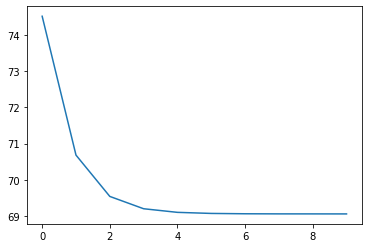

In [314]:
# let's look at the loss history!
plt.plot(loss_history)

In [315]:
def predict(self, X):
        '''
        Produces classifier predictions on the set
       
        Arguments:
          X, np array (test_samples, num_features)
        Returns:
          y_pred, np.array of int (test_samples)
        '''
        y_pred = np.zeros(X.shape[0], dtype=np.int)
        y_pred = np.argmax(linear_classifer.softmax(X@self.W),axis = 1)
        # TODO Implement class prediction
        # Your final implementation shouldn't have any loops

        return y_pred

In [316]:
def multiclass_accuracy(prediction, ground_truth):
  return sum([a == b for a, b in zip(prediction, ground_truth)])/len(ground_truth)

In [317]:
# Let's check how it performs on validation set
linear_classifer.LinearSoftmaxClassifier.predict = predict
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

# Now, let's train more and see if it performs better
classifier.fit(train_X, train_y, epochs=100, batch_size=300)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

Accuracy:  0.127
Epoch 0, loss: 69.056728
Epoch 1, loss: 69.056008
Epoch 2, loss: 69.055063
Epoch 3, loss: 69.056238
Epoch 4, loss: 69.056781
Epoch 5, loss: 69.055940
Epoch 6, loss: 69.056435
Epoch 7, loss: 69.055352
Epoch 8, loss: 69.056378
Epoch 9, loss: 69.056105
Epoch 10, loss: 69.055774
Epoch 11, loss: 69.055604
Epoch 12, loss: 69.056626
Epoch 13, loss: 69.056039
Epoch 14, loss: 69.056074
Epoch 15, loss: 69.056006
Epoch 16, loss: 69.056209
Epoch 17, loss: 69.055931
Epoch 18, loss: 69.056047
Epoch 19, loss: 69.056451
Epoch 20, loss: 69.055503
Epoch 21, loss: 69.055945
Epoch 22, loss: 69.055487
Epoch 23, loss: 69.056122
Epoch 24, loss: 69.056102
Epoch 25, loss: 69.055741
Epoch 26, loss: 69.056354
Epoch 27, loss: 69.056050
Epoch 28, loss: 69.055511
Epoch 29, loss: 69.055645
Epoch 30, loss: 69.055892
Epoch 31, loss: 69.055887
Epoch 32, loss: 69.055612
Epoch 33, loss: 69.056328
Epoch 34, loss: 69.056007
Epoch 35, loss: 69.055988
Epoch 36, loss: 69.055770
Epoch 37, loss: 69.055554
Epoch

### Как и раньше, используем кросс-валидацию для подбора гиперпараметтов.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

In [320]:
from sklearn.model_selection import cross_validate
num_epochs = 200
batch_size = 300

learning_rates = [1e-2,1e-3, 1e-4]
reg_strengths = [1e-2,1e-3,1e-4]

# TODO use validation set to find the best hyperparameters
# hint: for best results, you might need to try more values for learning rate and regularization strength 
# than provided initially
accuracy = 0
best_classifier = None
best_val_accuracy = 0
best_reg = 0
best_lr = 0
for lr in learning_rates:
  for reg in reg_strengths:
    clf = linear_classifer.LinearSoftmaxClassifier(lr,reg=reg)
    clf.fit(train_X, train_y,epochs=15,batch_size=300)
    accuracy = multiclass_accuracy(clf.predict(val_X), val_y)
    if accuracy>best_val_accuracy:
      best_lr = lr
      best_reg = reg
      best_val_accuracy = accuracy
print('best validation accuracy achieved: %f' % best_val_accuracy , f'with best lr = {best_lr} and best reg = {reg}')

Epoch 0, loss: 68.988784
Epoch 1, loss: 68.735996
Epoch 2, loss: 68.512316
Epoch 3, loss: 68.301110
Epoch 4, loss: 68.108784
Epoch 5, loss: 67.938688
Epoch 6, loss: 67.763803
Epoch 7, loss: 67.617016
Epoch 8, loss: 67.474918
Epoch 9, loss: 67.332475
Epoch 10, loss: 67.216729
Epoch 11, loss: 67.097946
Epoch 12, loss: 66.986568
Epoch 13, loss: 66.895757
Epoch 14, loss: 66.798842
Epoch 0, loss: 68.985426
Epoch 1, loss: 68.735395
Epoch 2, loss: 68.500275
Epoch 3, loss: 68.283524
Epoch 4, loss: 68.080251
Epoch 5, loss: 67.895419
Epoch 6, loss: 67.721133
Epoch 7, loss: 67.552364
Epoch 8, loss: 67.395576
Epoch 9, loss: 67.251536
Epoch 10, loss: 67.113564
Epoch 11, loss: 66.984199
Epoch 12, loss: 66.864211
Epoch 13, loss: 66.747352
Epoch 14, loss: 66.628112
Epoch 0, loss: 68.985369
Epoch 1, loss: 68.730485
Epoch 2, loss: 68.506237
Epoch 3, loss: 68.278958
Epoch 4, loss: 68.078535
Epoch 5, loss: 67.890983
Epoch 6, loss: 67.711309
Epoch 7, loss: 67.545421
Epoch 8, loss: 67.395109
Epoch 9, loss: 

# Какой же точности мы добились на тестовых данных?

In [321]:
best_classifier = linear_classifer.LinearSoftmaxClassifier(best_lr,best_reg)
best_classifier.fit(train_X, train_y,epochs=150)
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))

Epoch 0, loss: 206.475090
Epoch 1, loss: 204.594985
Epoch 2, loss: 203.132373
Epoch 3, loss: 201.878113
Epoch 4, loss: 200.915224
Epoch 5, loss: 200.118965
Epoch 6, loss: 199.419108
Epoch 7, loss: 198.953081
Epoch 8, loss: 198.439382
Epoch 9, loss: 198.055997
Epoch 10, loss: 197.729386
Epoch 11, loss: 197.465632
Epoch 12, loss: 197.202683
Epoch 13, loss: 196.951567
Epoch 14, loss: 196.830849
Epoch 15, loss: 196.685086
Epoch 16, loss: 196.516022
Epoch 17, loss: 196.391301
Epoch 18, loss: 196.288313
Epoch 19, loss: 196.104944
Epoch 20, loss: 196.050110
Epoch 21, loss: 195.965453
Epoch 22, loss: 195.896124
Epoch 23, loss: 195.869619
Epoch 24, loss: 195.769219
Epoch 25, loss: 195.682437
Epoch 26, loss: 195.632511
Epoch 27, loss: 195.568217
Epoch 28, loss: 195.543016
Epoch 29, loss: 195.489228
Epoch 30, loss: 195.479721
Epoch 31, loss: 195.394469
Epoch 32, loss: 195.407284
Epoch 33, loss: 195.335396
Epoch 34, loss: 195.320551
Epoch 35, loss: 195.293985
Epoch 36, loss: 195.241540
Epoch 37, l